In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis

from nelson_siegel_svensson.calibrate import betas_ns_ols, errorfn_ns_ols

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

2023-06-25 20:00:16.562088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Prep

In [2]:
wti = pd.read_excel("WTI.xlsx")
wti.set_index('Dates',inplace= True)

In [3]:
wti

,CL1 Comdty,CL2 Comdty,CL3 Comdty,CL4 Comdty,CL5 Comdty,CL6 Comdty,CL7 Comdty,CL8 Comdty,CL9 Comdty,CL10 Comdty,CL11 Comdty,CL12 Comdty,CL24 Comdty
Dates,,,,,,,,,,,,,
2000-01-03,25.60,24.79,23.99,23.23,22.57,22.00,21.56,21.18,20.83,20.49,20.21,19.95,18.40
2000-01-04,25.55,24.84,24.13,23.43,22.79,22.23,21.79,21.42,21.09,20.77,20.50,20.24,18.69
2000-01-05,24.91,24.27,23.61,22.99,22.41,21.89,21.46,21.10,20.77,20.45,20.18,19.92,18.35
2000-01-06,24.78,24.20,23.54,22.92,22.34,21.82,21.39,21.03,20.70,20.38,20.11,19.85,18.28
2000-01-07,24.22,23.76,23.25,22.75,22.27,21.79,21.38,21.05,20.74,20.45,20.19,19.95,18.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07,72.53,72.64,72.44,72.09,71.71,71.32,70.93,70.55,70.18,69.83,69.50,69.18,65.68
2023-06-08,71.29,71.44,71.31,71.00,70.64,70.25,69.88,69.52,69.17,68.83,68.50,68.18,64.77
2023-06-09,70.17,70.33,70.27,70.02,69.71,69.38,69.05,68.72,68.40,68.09,67.80,67.51,64.41


In [4]:
# Summary stats
summary_stats = pd.DataFrame({
    'Mean': wti.mean(),
    'Std': wti.std(),
    'Skewness': skew(wti),
    'Kurtosis': kurtosis(wti, fisher=False)
}).T
summary_stats

,CL1 Comdty,CL2 Comdty,CL3 Comdty,CL4 Comdty,CL5 Comdty,CL6 Comdty,CL7 Comdty,CL8 Comdty,CL9 Comdty,CL10 Comdty,CL11 Comdty,CL12 Comdty,CL24 Comdty
Mean,62.774376,62.987855,63.079508,63.086237,63.045933,62.970667,62.872142,62.761108,62.643459,62.522048,62.399894,62.276188,60.947795
Std,25.930945,25.797634,25.708275,25.642010,25.590274,25.545898,25.506531,25.471452,25.437302,25.404178,25.372094,25.338317,24.898087
Skewness,0.308263,0.289341,0.263359,0.240282,0.220191,0.203060,0.188731,0.176314,0.165109,0.154842,0.145170,0.135935,0.072502
Kurtosis,2.308689,2.279322,2.280436,2.286497,2.295875,2.306722,2.317655,2.327713,2.336067,2.343237,2.349376,2.354878,2.427765


In [5]:
maturities = np.array([1,2,3,4,5,6,7,8,9,10,11,12,24])
maturities

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 24])

In [6]:
### Data Prep
#Nieson-Siegel Parameters Extraction

In [7]:
thetas = range(1,13) # Change for greater time scaling parameter

ns = {}
for index, row in wti.iterrows():
  ns[str(index.date())] = [betas_ns_ols(theta, maturities, np.array(row)) for theta in thetas]

In [8]:
# ns

In [9]:
# Selecting a fitted model for each date that has least MSE (optimal)
ns_optimal = {}
for date, models in ns.items():
  ns_optimal[date] = sorted(ns[date], key=lambda x: x[1][1][0]/len(maturities))[0]
# ns_optimal

In [10]:
# Storing the results in the Pandas dataframe object
df = pd.DataFrame(columns=['Beta 0','Beta 1','Beta 2','Lambda', 'MSE'], index=ns_optimal.keys())

for date, model in ns_optimal.items():
  df.loc[date] = pd.Series({'Beta 0': model[0].beta0, 'Beta 1': model[0].beta1, 'Beta 2': model[0].beta2, 'Lambda': model[0].tau, 'MSE': model[1][1][0]/len(maturities)})

df

,Beta 0,Beta 1,Beta 2,Lambda,MSE
2000-01-03,16.716129,9.952122,3.504021,3.0,0.001113
2000-01-04,16.992603,9.496079,4.025355,3.0,0.001438
2000-01-05,16.643654,9.017464,4.681373,3.0,0.000517
2000-01-06,16.550293,8.972789,4.837541,3.0,0.000874
2000-01-07,16.834617,7.900602,5.260278,3.0,0.000618
...,...,...,...,...,...
2023-06-07,60.49652,12.021454,13.866048,5.0,0.005319
2023-06-08,59.62316,11.612556,14.035773,5.0,0.004984
2023-06-09,59.658136,10.404866,13.237469,5.0,0.003546
2023-06-12,58.974499,7.963353,11.17658,5.0,0.001828


In [12]:
original_data = np.array(wti.values).T
dates = list(ns_optimal.keys())

fig = go.Figure(data=[go.Surface(z=original_data, x=dates, y=maturities)])
fig.update_layout(
    title='Observed Spot Prices',
    autosize=False,
    scene=dict(
        xaxis_title='Year',
        yaxis_title='Maturity',
        zaxis_title='Price'
    )
)
fig.show()

# LSTM-Base Model

In [14]:
# Sort the data by dates in ascending order
wti.sort_values('Dates', inplace=True)

# Extract the target variable (next day's prices) for all columns
target_columns = [col for col in wti.columns if col != 'Dates']
target_data = wti[target_columns].values

# Normalize the target data using MinMaxScaler
scaler = MinMaxScaler()
target_data = scaler.fit_transform(target_data)

# Prepare input sequences
sequence_length = 300  # Number of past days' prices to consider

X = []
y = []

for i in range(len(wti) - sequence_length):
    X.append(target_data[i:i + sequence_length])
    # Only last step y is kept for each subsample
    y.append(target_data[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(wti))
val_size = int(0.1 * len(wti))

# Manually split
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


In [15]:
train_size

4893

In [16]:
val_size

611

In [17]:
y_test.shape

(313, 13)

In [18]:
y_val.shape

(611, 13)

In [19]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, kernel_initializer= 'glorot_uniform',input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False,kernel_initializer= 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units=len(target_columns)))

model.compile(optimizer='adam', loss='mean_squared_error')
# mean_squared_error
# mean_absolute_error

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 50)           12800     
                                                                 
 dropout (Dropout)           (None, 300, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 13)                663       
                                                                 
Total params: 33,663
Trainable params: 33,663
Non-trainable params: 0
_________________________________________________________________


In [21]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
training = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
153/153 [==============================] - 38s 234ms/step - loss: 0.0161 - val_loss: 0.0014
Epoch 2/100
153/153 [==============================] - 35s 230ms/step - loss: 0.0046 - val_loss: 6.6348e-04
Epoch 3/100
153/153 [==============================] - 35s 232ms/step - loss: 0.0034 - val_loss: 9.6486e-04
Epoch 4/100
153/153 [==============================] - 36s 236ms/step - loss: 0.0027 - val_loss: 5.8648e-04
Epoch 5/100
153/153 [==============================] - 36s 236ms/step - loss: 0.0022 - val_loss: 4.5229e-04
Epoch 6/100
153/153 [==============================] - 36s 232ms/step - loss: 0.0019 - val_loss: 6.3236e-04
Epoch 7/100
153/153 [==============================] - 36s 232ms/step - loss: 0.0017 - val_loss: 6.2067e-04
Epoch 8/100
153/153 [==============================] - 36s 233ms/step - loss: 0.0015 - val_loss: 4.2829e-04
Epoch 9/100
153/153 [==============================] - 36s 233ms/step - loss: 0.0013 - val_loss: 3.7767e-04
Epoch 10/100
153/153 [==========

In [22]:
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")
print(f"Testing loss: {test_loss}")
 

10/10 [==============================] - 1s 59ms/step - loss: 2.7266e-04
Training loss: 0.00011957388778682798
Validation loss: 0.00018494389951229095
Testing loss: 0.00027265920653007925


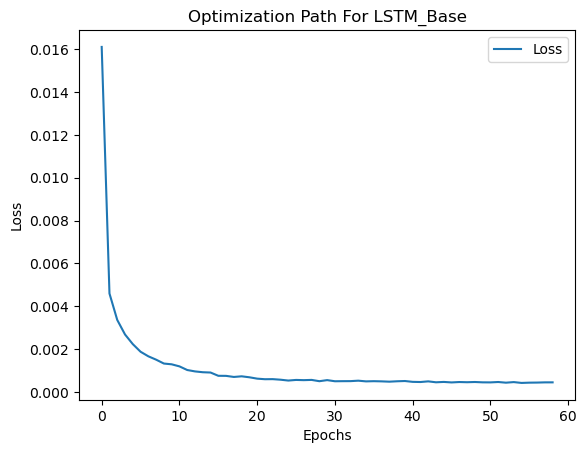

In [23]:
train_loss = training.history['loss']
val_loss = training.history['val_loss']

# Plot the optimization path
plt.plot(train_loss, label= 'Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Optimization Path For LSTM_Base')
plt.legend()
plt.show()

In [24]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Denormalize the predicted values
y_pred_denormalized = scaler.inverse_transform(y_pred)

y_test_denormalized = scaler.inverse_transform(y_test)

# Print the predicted values
print("Predicted Values for the Test Set:")
print(y_pred_denormalized)
print("True Values for the Test Set:")
print(y_test_denormalized)

10/10 [==============================] - 1s 57ms/step
Predicted Values for the Test Set:
[[101.89746  100.33332   98.63463  ...  87.63736   86.52358   76.88988 ]
 [101.363174  99.93433   98.34537  ...  87.95632   86.889404  77.703476]
 [103.55782  102.24355  100.72943  ...  90.718475  89.674736  80.703064]
 ...
 [ 71.64302   71.55969   71.30912  ...  68.683754  68.34455   65.46652 ]
 [ 70.71834   70.6423    70.40605  ...  67.87049   67.54099   64.75257 ]
 [ 68.45135   68.403366  68.211845 ...  65.94695   65.64601   63.115093]]
True Values for the Test Set:
[[ 99.27  97.9   96.76 ...  88.91  88.19  81.81]
 [103.28 101.84 100.6  ...  91.66  90.83  83.37]
 [101.96 100.68  99.55 ...  90.93  90.08  82.51]
 ...
 [ 70.17  70.33  70.27 ...  67.8   67.51  64.41]
 [ 67.12  67.29  67.3  ...  65.51  65.29  62.82]
 [ 69.42  69.58  69.59 ...  67.62  67.37  64.62]]


In [25]:
# Compute RMSE for each output series
rmse = np.sqrt(mean_squared_error(y_test_denormalized, y_pred_denormalized, multioutput='raw_values'))

# Create a dataframe to display the RMSE values
df_rmse = pd.DataFrame({'Output Series': target_columns, 'RMSE': rmse})

# Compute MAPE for each output series
mape = mean_absolute_percentage_error(y_test_denormalized, y_pred_denormalized, multioutput='raw_values')*100

# Create a dataframe to display the MAPE values
df_mape = pd.DataFrame({'Output Series': target_columns, 'MAPE (%)': mape})

df_rmse

,Output Series,RMSE
0,CL1 Comdty,2.931627
1,CL2 Comdty,2.605053
2,CL3 Comdty,2.344816
3,CL4 Comdty,2.186073
4,CL5 Comdty,2.114476
5,CL6 Comdty,2.083873
6,CL7 Comdty,2.068309
7,CL8 Comdty,2.046275
8,CL9 Comdty,2.030373
9,CL10 Comdty,2.003740


In [26]:
df_mape

,Output Series,MAPE (%)
0,CL1 Comdty,2.573491
1,CL2 Comdty,2.345881
2,CL3 Comdty,2.149648
3,CL4 Comdty,2.017089
4,CL5 Comdty,1.946519
5,CL6 Comdty,1.919271
6,CL7 Comdty,1.903644
7,CL8 Comdty,1.891674
8,CL9 Comdty,1.893624
9,CL10 Comdty,1.886269


# LSTM_NS

In [27]:
# Extract the target variable for all columns
ns_target_columns = df.columns.tolist()
ns_target_columns = [col for col in ns_target_columns if col != 'MSE']
ns_target_data = df[ns_target_columns].values

# Normalize the target data using MinMaxScaler
scaler = MinMaxScaler()
ns_target_data = scaler.fit_transform(ns_target_data)

# Prepare input sequences and corresponding targets
sequence_length = 300  # Number of past days' prices to consider

X = []
y = []

for i in range(len(wti) - sequence_length):
    X.append(ns_target_data[i:i + sequence_length])
    # Only last step y is kept for each subsample
    y.append(ns_target_data[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))

# Manually split
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


In [28]:
# Input shape: need to specify 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, kernel_initializer= 'glorot_uniform', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False, kernel_initializer= 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(units=len(ns_target_columns)))

model.compile(optimizer='adam', loss='mean_squared_error')
# mean_squared_error

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
training = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
153/153 [==============================] - 39s 238ms/step - loss: 0.0259 - val_loss: 0.0074
Epoch 2/100
153/153 [==============================] - 36s 233ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 3/100
153/153 [==============================] - 36s 236ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 4/100
153/153 [==============================] - 36s 237ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 5/100
153/153 [==============================] - 37s 240ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 6/100
153/153 [==============================] - 36s 236ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 7/100
153/153 [==============================] - 38s 249ms/step - loss: 0.0070 - val_loss: 0.0046
Epoch 8/100
153/153 [==============================] - 38s 250ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 9/100
153/153 [==============================] - 37s 241ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 10/100
153/153 [==============================] - 36s 234m

In [30]:
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")
print(f"Testing loss: {test_loss}")

10/10 [==============================] - 1s 59ms/step - loss: 0.0021
Training loss: 0.003781582461670041
Validation loss: 0.004143766593188047
Testing loss: 0.002123368438333273


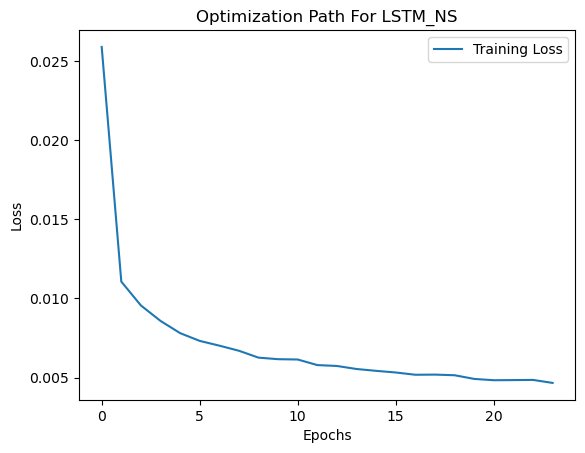

In [31]:
train_loss = training.history['loss']
val_loss = training.history['val_loss']

# Plot the optimization path
plt.plot(train_loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Optimization Path For LSTM_NS')
plt.legend()
plt.show()

In [32]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Denormalize the predicted values
y_pred_denormalized = scaler.inverse_transform(y_pred)

y_test_denormalized = scaler.inverse_transform(y_test)


# print("Predicted Values for the Test Set:")
# print(y_pred_denormalized)
# print("True Values for the Test Set:")
# print(y_test_denormalized)

10/10 [==============================] - 1s 58ms/step


In [33]:
def nelson_siegel(maturity, beta0, beta1, beta2, theta):
    return beta0 + beta1 * (1 - np.exp(-maturity / theta)) / (maturity / theta) + beta2 * ((1 - np.exp(-maturity / theta)) / (maturity / theta) - np.exp(-maturity / theta))

In [34]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
y_pred_denormalized_df = pd.DataFrame(y_pred_denormalized)
y_pred_denormalized_df

y_pred_adj_df=pd.DataFrame(columns=[maturities])

# Iterate over each row in the DataFrame
for index, row in y_pred_denormalized_df.iterrows():
    # Extract the parameters from the row
    beta0 = row[0]
    beta1 = row[1]
    beta2 = row[2]
    # rename to theta, since it was specified in the package, and to avoid the lambda operation in Python
    theta = row[3]
    
    # Calculate the prices using the Nelson-Siegel equation
    prices = [nelson_siegel(maturity, beta0, beta1, beta2, theta) for maturity in maturities]
    
    # Create a DataFrame to store the adjusted prices
    y_pred_adj_df.loc[index] =prices
    
    # Print the adjusted prices DataFrame
y_pred_adj_df

,1,2,3,4,5,6,7,8,9,10,11,12,24
0,96.103063,94.991159,93.911783,92.867789,91.861123,90.892995,89.964006,89.074270,88.223507,87.411127,86.636298,85.898000,79.417832
1,96.769240,95.824923,94.903780,94.007456,93.137160,92.293728,91.477680,90.689271,89.928533,89.195310,88.489295,87.810054,81.501282
2,95.499583,94.283848,93.120089,92.009272,90.951542,89.946395,88.992833,88.089480,87.234686,86.426604,85.663256,84.942589,78.897676
3,95.935771,94.781769,93.672362,92.609106,91.592725,90.623281,89.700314,88.822958,87.990041,87.200160,86.451748,85.743128,79.714335
4,95.076700,94.016043,92.988836,91.998076,91.045737,90.132961,89.260226,88.427479,87.634253,86.879756,86.162953,85.482628,79.640623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,65.497757,65.872417,66.100709,66.216087,66.245217,66.209287,66.125076,66.005817,65.861897,65.701424,65.530680,65.354496,63.528876
309,65.542122,65.915348,66.140819,66.252426,66.277167,66.236483,66.147338,66.023104,65.874267,65.709004,65.533644,65.353050,63.491128
310,65.555880,65.929106,66.153348,66.262768,66.284586,66.240427,66.147411,66.019033,65.865883,65.696217,65.516432,65.331439,63.426546
311,65.511104,65.887787,66.114117,66.224495,66.246349,66.201484,66.107171,65.977036,65.821776,65.649740,65.467400,65.279730,63.344358


In [36]:
y_test_denormalized_df = pd.DataFrame(y_test_denormalized)
y_test_denormalized_df

y_test_adj_df=pd.DataFrame(columns=[maturities])
# Iterate over each row in the DataFrame
for index, row in y_test_denormalized_df.iterrows():
    # Extract the parameters from the row
    beta0 = row[0]
    beta1 = row[1]
    beta2 = row[2]
    theta = row[3]
    
    # Calculate the prices using the Nelson-Siegel equation
    prices = [nelson_siegel(maturity, beta0, beta1, beta2, theta) for maturity in maturities]
    
    # Create a DataFrame to store the adjusted prices
    y_test_adj_df.loc[index] = prices
    
    # Print the adjusted prices DataFrame
y_test_adj_df

,1,2,3,4,5,6,7,8,9,10,11,12,24
0,99.279257,97.926000,96.655346,95.461633,94.339611,93.284410,92.291516,91.356741,90.476199,89.646281,88.863639,88.125163,81.834205
1,103.315696,101.878241,100.501647,99.186498,97.932607,96.739178,95.604947,94.528291,93.507321,92.539964,91.624018,90.757210,83.384382
2,102.007847,100.715067,99.455439,98.233799,97.053600,95.917160,94.825878,93.780404,92.780792,91.826621,90.917096,90.051141,82.505155
3,96.255940,95.424013,94.574610,93.718592,92.864693,92.019862,91.189557,90.377993,89.588353,88.822962,88.083443,87.370843,80.869138
4,96.055259,95.467907,94.820918,94.131405,93.413468,92.678666,91.936409,91.194297,90.458414,89.733567,89.023502,88.331078,81.735110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,72.607000,72.538306,72.353571,72.085475,71.759508,71.395427,71.008425,70.610079,70.209104,69.811960,69.423339,69.046554,65.731251
309,71.377908,71.354050,71.207211,70.971221,70.672524,70.331667,69.964502,69.583149,69.196779,68.812227,68.434504,68.067182,64.807076
310,70.248354,70.270805,70.171836,69.984094,69.733149,69.438920,69.116821,68.778680,68.433487,68.087985,67.747150,67.414572,64.434146
311,67.171296,67.257744,67.233520,67.127296,66.961610,66.754091,66.518448,66.265266,66.002647,65.736726,65.472084,65.212082,62.837189


In [37]:
# def rmse(y_true, y_pred):
#     return np.sqrt(np.mean((y_true - y_pred)**2))

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_values = []
mape_values = []

for column in y_test_adj_df.columns:
    y_true = y_test_adj_df[column]
    y_pred = y_pred_adj_df[column]
    
    rmse_val = rmse(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    
    rmse_values.append(rmse_val)
    mape_values.append(mape_val)

rmse_df = pd.DataFrame({'RMSE': rmse_values}, index=y_test_adj_df.columns)
mape_df = pd.DataFrame({'MAPE (%)': mape_values}, index=y_pred_adj_df.columns)

In [38]:
rmse_df

,RMSE
1,9.497354
2,8.829428
3,8.237074
4,7.708636
5,7.234962
6,6.808691
7,6.423782
8,6.075194
9,5.758666
10,5.470562


In [44]:
# rmse_df.to_csv('ns-wti_rmse.csv')
# df_rmse.to_csv("base-wti_rmse.csv")
# df_mape.to_csv("base-wti_mape.csv")
# mape_df.to_csv('ns-wti_mape.csv')

In [43]:
mape_df

,MAPE (%)
1,8.905731
2,8.387324
3,7.923150
4,7.499036
5,7.111868
6,6.762030
7,6.447607
8,6.162439
9,5.899640
10,5.656433
